# Задача классификации: превышает ли значение SI медианное значение выборки

In [38]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,  FunctionTransformer
from sklearn.pipeline import Pipeline

from catboost import  Pool
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 62025


In [39]:
# Прочитаем обработанный датасет
df = pd.read_csv('./data_him.csv')

In [40]:
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,Polar_Groups_Count,Lipophilic_Groups_Count,PLB,HBond_Capacity,HBond_Donor_Acceptor_Ratio,Saturation_Index,Hydrophobic_VSA,BCUT_Electronic,Size_Flexibility,LogD
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,3,0.0,2,0.0,1.000000,173.744106,38.545778,26.92564,7.1212
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,3,0.0,4,1.0,1.000000,175.053185,39.145933,34.98156,6.1556
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,3,0.0,0,0.0,1.000000,201.576358,40.922447,40.21272,7.1292
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,4,0.0,2,0.0,1.000000,180.164927,38.542997,31.89432,7.5113
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0.0,2,0.0,0.666667,201.049968,38.597756,18.66852,9.1148


In [41]:
df.shape

(970, 213)

In [42]:
cat_features = ['NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 
                'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
                'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
                'RingCount', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_N', 'fr_Ar_OH',
                'fr_C_O', 'fr_C_O_noCOO', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 
                'fr_Ndealkylation2', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline',
                'fr_aryl_methyl', 'fr_benzene', 'fr_bicyclic', 'fr_epoxide', 'fr_ester', 
                'fr_ether', 'fr_furan', 'fr_halogen', 'fr_hdrzone', 'fr_ketone', 'fr_ketone_Topliss',
                'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_oxime', 'fr_para_hydroxylation', 
                'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_piperdine', 'fr_piperzine', 'fr_quatN', 
                'fr_sulfide']
numeric_features = [ 'MaxAbsEStateIndex', 'MaxEStateIndex', 
                    'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 
                    'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
                    'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 
                    'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
                    'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 
                    'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ',
                    'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
                    'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 
                    'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10',
                    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 
                    'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 
                    'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4',
                    'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
                    'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 
                    'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10',
                    'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
                    'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10',
                    'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6',
                    'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount',
                    'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 
                    'NumRotatableBonds', 'MolLogP', 'MolMR', 'fr_NH0', 'fr_unbrch_alkane']
bool_features = ['fr_Al_COO', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_COO', 'fr_COO2', 'fr_C_S', 'fr_HOCCN', 
                 'fr_Nhpyrrole', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azo', 
                 'fr_guanido', 'fr_hdrzine', 'fr_imidazole', 'fr_imide', 'fr_nitrile', 'fr_nitro',
                 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_oxazole', 'fr_priamide', 
                 'fr_pyridine', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
                 'fr_thiazole', 'fr_thiophene', 'fr_urea']

In [43]:
# Резделение выборки
y = (df['SI'] > df['SI'].median()).astype(int)
X = df.drop(['IC50, mM','CC50, mM', 'SI', 'Unnamed: 0'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.15, random_state=RANDOM_STATE)

In [44]:
y.value_counts()

SI
1    485
0    485
Name: count, dtype: int64

In [45]:
X_train.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'Polar_Groups_Count', 'Lipophilic_Groups_Count', 'PLB',
       'HBond_Capacity', 'HBond_Donor_Acceptor_Ratio', 'Saturation_Index',
       'Hydrophobic_VSA', 'BCUT_Electronic', 'Size_Flexibility', 'LogD'],
      dtype='object', length=209)

In [46]:
# Создаем копии данных для обработки
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Преобразование типов данных
X_train_processed[cat_features] = X_train_processed[cat_features].astype('category')
X_test_processed[cat_features] = X_test_processed[cat_features].astype('category')

# Исправление: Преобразование bool в int (0/1) до масштабирования
X_train_processed[bool_features] = X_train_processed[bool_features].astype(int)
X_test_processed[bool_features] = X_test_processed[bool_features].astype(int)

# Масштабирование только числовых признаков
scaler = StandardScaler()
X_train_processed[numeric_features] = scaler.fit_transform(X_train_processed[numeric_features])
X_test_processed[numeric_features] = scaler.transform(X_test_processed[numeric_features])


## CatBoost модель

In [10]:
# Настройка GridSearchCV, Обучение модели
model_cat = CatBoostClassifier(loss_function="Logloss", verbose=10,\
                               cat_features=cat_features,\
                               eval_metric='AUC:hints=skip_train~false',\
                               random_state=RANDOM_STATE, auto_class_weights="SqrtBalanced")#task_type="GPU", devices='0-3',) 

grid = {'learning_rate': [0.1, 0.05, 0.5],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5],
        'iterations': [200] }

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=model_cat,
    param_grid=grid,
    cv=5,
    #n_jobs=-1
)
# Обучение модели
grid_search.fit(X_train_processed, y_train)

0:	learn: 0.6471746	total: 183ms	remaining: 36.3s
10:	learn: 0.7823092	total: 424ms	remaining: 7.28s
20:	learn: 0.8329801	total: 653ms	remaining: 5.57s
30:	learn: 0.8617736	total: 869ms	remaining: 4.74s
40:	learn: 0.8890927	total: 1.09s	remaining: 4.24s
50:	learn: 0.8999576	total: 1.33s	remaining: 3.88s
60:	learn: 0.9149833	total: 1.55s	remaining: 3.54s
70:	learn: 0.9307324	total: 1.78s	remaining: 3.24s
80:	learn: 0.9427724	total: 2s	remaining: 2.94s
90:	learn: 0.9519509	total: 2.22s	remaining: 2.65s
100:	learn: 0.9604659	total: 2.44s	remaining: 2.4s
110:	learn: 0.9670227	total: 2.66s	remaining: 2.13s
120:	learn: 0.9716580	total: 2.9s	remaining: 1.9s
130:	learn: 0.9749571	total: 3.12s	remaining: 1.64s
140:	learn: 0.9774084	total: 3.34s	remaining: 1.4s
150:	learn: 0.9800855	total: 3.57s	remaining: 1.16s
160:	learn: 0.9825506	total: 3.78s	remaining: 917ms
170:	learn: 0.9852047	total: 4s	remaining: 679ms
180:	learn: 0.9868266	total: 4.23s	remaining: 444ms
190:	learn: 0.9879324	total: 4.45

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C54E43C770>,
             param_grid={'depth': [4, 6, 8], 'iterations': [200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.05, 0.5]})

In [28]:
# Лучшая модель КатБуст
best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучшая AUC (кросс-валидация):", grid_search.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test, average='weighted')
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Лучшая AUC (кросс-валидация): 0.6650406504065041

Тестовая roc_auc_score: 0.7008032128514056
Тестовый f1_score: 0.7052124088473997


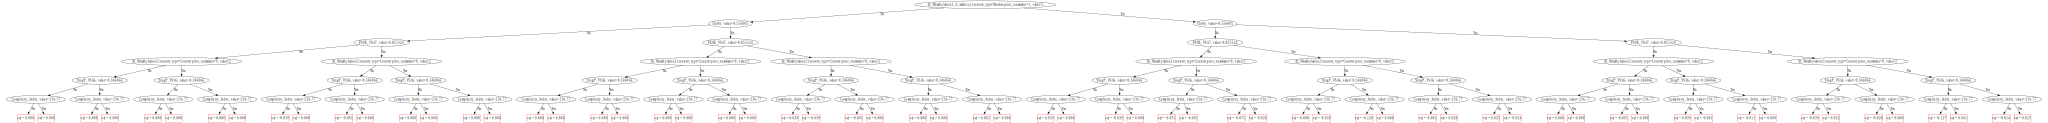

In [29]:
# Как модель принимает решение
pool = Pool(X_train_processed, y_train, cat_features=cat_features, feature_names=list(X_train_processed.columns))

best_model.plot_tree(
    tree_idx=0,
    pool=pool
)

## Модель GradientBoostingClassifier

In [47]:
# Модель Градиентного бустинг
model_gb = GradientBoostingClassifier(random_state=62025)
grid = {'learning_rate': [0.1, 0.05],
        'max_depth': [4, 6, 8, 12],
        'max_leaf_nodes': [2, 3, 5, 8],
        'n_estimators': [100, 200] }

# Настройка GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=model_gb,
    param_grid=grid,
    cv=3,
    n_jobs=-1
)
# Обучение модели
grid_search_gb.fit(X_train_processed, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=62025),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05],
                         'max_depth': [4, 6, 8, 12],
                         'max_leaf_nodes': [2, 3, 5, 8],
                         'n_estimators': [100, 200]})

In [48]:
# Лучшая модель ГБ
best_model_gb = grid_search_gb.best_estimator_
print("\nЛучшие параметры:", grid_search_gb.best_params_)
print("Лучшая AUC (кросс-валидация):", grid_search_gb.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_gb.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test)
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100}
Лучшая AUC (кросс-валидация): 0.6553328909533289

Тестовая roc_auc_score: 0.7106521323388792
Тестовый f1_score: 0.676923076923077


In [50]:
grid_s = {'learning_rate': [0.01, 0.5],
        'max_depth': [2, 12],
        'max_leaf_nodes': [2,  8],
        'n_estimators': [100, 200] }
search_r = RandomizedSearchCV(model_gb, grid_s, n_iter=16, cv=3,
                                       n_jobs=-1, random_state=62025,
                                       scoring='accuracy')
search_r.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(random_state=62025),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.5],
                                        'max_depth': [2, 12],
                                        'max_leaf_nodes': [2, 8],
                                        'n_estimators': [100, 200]},
                   random_state=62025, scoring='accuracy')

In [51]:
# Лучшая модель ГБ серч
best_model_gb_search_r = search_r.best_estimator_
print("\nЛучшие параметры:", search_r.best_params_)
print("Лучшая AUC (кросс-валидация):", search_r.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_gb_search_r.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test)
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'n_estimators': 200, 'max_leaf_nodes': 8, 'max_depth': 12, 'learning_rate': 0.01}
Лучшая AUC (кросс-валидация): 0.657788099977881

Тестовая roc_auc_score: 0.7087397207879136
Тестовый f1_score: 0.671875


In [56]:
# Базовое решение
y_base = np.ones(len(y_pred))
test_f1_base = f1_score(y_base, y_test)
test_f1_base

0.6028708133971292

## Модель Логистической регрессии

In [52]:
# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Проверка баланса классов
print("\nРаспределение классов:")
print(f"Обучающая выборка: {np.unique(y_train, return_counts=True)}")
print(f"Тестовая выборка: {np.unique(y_test, return_counts=True)}")

# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop'
)

# Применяем преобразования
X_train_pt = preprocessor.fit_transform(X_train)
X_test_pt = preprocessor.transform(X_test)


# поищем лучшую модель Логистической регрессии
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train_pt, y_train)
search.best_params_


Распределение классов:
Обучающая выборка: (array([0, 1]), array([388, 388], dtype=int64))
Тестовая выборка: (array([0, 1]), array([97, 97], dtype=int64))


{'C': 2.195254015709299, 'penalty': 'l1'}

In [61]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0, C = 2.195254015709299, penalty = 'l1')

In [62]:
logistic = logistic.fit(X_train_pt, y_train)

In [63]:
# Коэффициенты
print(logistic.coef_, logistic.intercept_)

[[ 9.13869698e-07  9.13869698e-07  3.50348849e-02  6.83424572e-02
   5.22850117e-02  1.60316644e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.77524677e-02 -9.27266881e-02 -1.71286002e-01
   1.82903641e-01 -1.09193062e-01 -2.86005932e-03 -1.79313070e-02
  -9.89806629e-02  8.03770709e-02 -1.64539053e-01  1.35638266e-01
   2.26123961e-01  2.45450131e-01 -2.84214564e-03 -2.91493654e-01
  -4.25184990e-02  2.33932421e-01 -3.68887872e-02 -7.72697274e-07
  -2.35829447e-02 -3.44664004e-02 -7.56739245e-03 -2.05943872e-02
  -2.13120407e-02 -2.49385488e-02  0.00000000e+00 -3.56860683e-06
  -3.91583021e-02 -2.28993879e-06 -2.46615122e-01 -1.38362467e-01
   9.28484888e-05 -8.25965137e-02 -1.39213889e-02 -7.77972471e-07
   2.03368424e-01 -7.13811717e-07  0.00000000e+00 -4.97905779e-02
  -6.15600429e-05 -5.78459962e-02  1.05318972e-01 -1.72601012e-01
  -1.42542328e-01  2.97473012e-01 -4.92699919e-03 -7.06465314e-02
   2.34673215e-01 -6.92666099e-02 -5.33332550e-03 -1.57632680e-01
  -1.17290

In [ ]:
# Из-за высокой мультиколлинеарности в данных многие коэффициенты занулились

In [55]:
# Лучшая модель Логистической регрессии 
best_model_search_l = search.best_estimator_
print("\nЛучшие параметры:", search.best_params_)
print("Лучшая AUC (кросс-валидация):", search.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_search_l.predict(X_test_pt)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test)
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'C': 2.195254015709299, 'penalty': 'l1'}
Лучшая AUC (кросс-валидация): 0.6455748552522746

Тестовая roc_auc_score: 0.6494845360824741
Тестовый f1_score: 0.6530612244897959


## Нейронная сеть на библиотеке PyTorch - Tensorflow не увидел мою GPU из-за конфликта библиотек

In [26]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [27]:

X = df[cat_features + numeric_features + bool_features]  # Исправлено: используем только нужные признаки

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=62025, stratify=y
)

# Проверка баланса классов
print("\nРаспределение классов:")
print(f"Обучающая выборка: {np.unique(y_train, return_counts=True)}")
print(f"Тестовая выборка: {np.unique(y_test, return_counts=True)}")

# ПРЕДОБРАБОТКА
# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop'
)

# Применяем преобразования
X_train_pt = preprocessor.fit_transform(X_train)
X_test_pt = preprocessor.transform(X_test)

# Определяем количество классов
num_classes = len(np.unique(y))
print(f"\nКоличество классов: {num_classes}")

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_pt.astype(np.float32))
y_train_tensor = torch.tensor(np.array(y_train).astype(np.int64))
X_test_tensor = torch.tensor(X_test_pt.astype(np.float32))
y_test_tensor = torch.tensor(np.array(y_test).astype(np.int64))

# Создание DataLoader 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем размерность входа
input_dim = X_train_pt.shape[1]
print(f"Размерность входных данных: {input_dim}")



Распределение классов:
Обучающая выборка: (array([0, 1]), array([388, 388], dtype=int64))
Тестовая выборка: (array([0, 1]), array([97, 97], dtype=int64))

Количество классов: 2
Размерность входных данных: 406


In [196]:
# Архитектура сети

class ClassificationNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Sigmoid(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 256),
            nn.Sigmoid(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.7),
            
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
  
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
                        
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

# Инициализация модели
model_pt = ClassificationNN(input_dim, num_classes).to(device)
print(model_pt)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# ОБУЧЕНИЕ 

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    
    return train_loss / len(loader.dataset), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item() * inputs.size(0)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return val_loss / len(loader.dataset), correct / total, np.array(all_preds), np.array(all_targets)

num_epochs = 100
best_accuracy = 0.0
patience = 10
patience_counter = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Обучение
    train_loss, train_acc = train_epoch(model_pt, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Валидация
    val_loss, val_acc, val_preds, val_targets = validate(model_pt, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Планировщик
    scheduler.step(val_loss)
    
    # Вывод статистики
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | '
          f'LR: {current_lr:.6f}')
    
    # Сохранение лучшей модели
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_pt.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': best_accuracy,
        }, 'best_classification_model.pth')
        print(f"Новая лучшая модель сохранена с точностью: {best_accuracy:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка на эпохе {epoch+1}')
            break

ClassificationNN(
  (layers): Sequential(
    (0): Linear(in_features=406, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): Sigmoid()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): Sigmoid()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): Sigmoid()
    (14): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=32, out_features=2, bias=True)
  )
)


D:\jupiter\conda_inst\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] | Train Loss: 0.7393, Acc: 0.5696 | Val Loss: 0.7140, Acc: 0.4485 | LR: 0.010000
Новая лучшая модель сохранена с точностью: 0.4485
Epoch [2/100] | Train Loss: 0.7005, Acc: 0.5593 | Val Loss: 0.6775, Acc: 0.5876 | LR: 0.010000
Новая лучшая модель сохранена с точностью: 0.5876
Epoch [3/100] | Train Loss: 0.6703, Acc: 0.6289 | Val Loss: 0.6719, Acc: 0.6134 | LR: 0.010000
Новая лучшая модель сохранена с точностью: 0.6134
Epoch [4/100] | Train Loss: 0.6442, Acc: 0.6598 | Val Loss: 0.6928, Acc: 0.6392 | LR: 0.010000
Новая лучшая модель сохранена с точностью: 0.6392
Epoch [5/100] | Train Loss: 0.6411, Acc: 0.6611 | Val Loss: 0.6584, Acc: 0.6340 | LR: 0.010000
Epoch [6/100] | Train Loss: 0.6189, Acc: 0.6894 | Val Loss: 0.6898, Acc: 0.6082 | LR: 0.010000
Epoch [7/100] | Train Loss: 0.6306, Acc: 0.6637 | Val Loss: 0.6628, Acc: 0.6495 | LR: 0.010000
Новая лучшая модель сохранена с точностью: 0.6495
Epoch [8/100] | Train Loss: 0.6007, Acc: 0.6920 | Val Loss: 0.6551, Acc: 0.6340 | LR:

C:\Users\ipd08\AppData\Local\Temp\ipykernel_5508\2563217785.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_classification_model.pth')


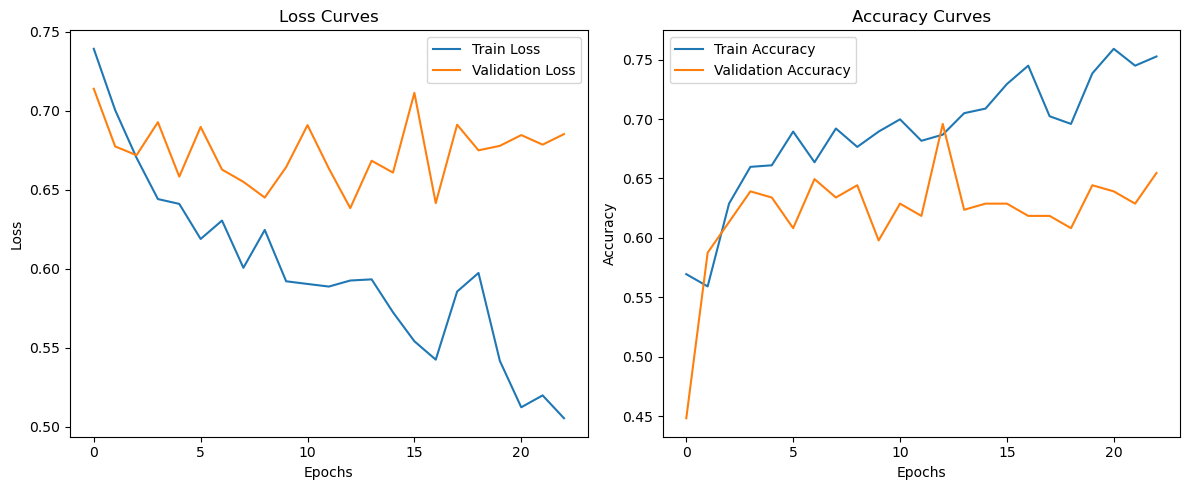


Классификационные метрики:
Accuracy: 0.6959
Precision: 0.6939
Recall: 0.7010
F1: 0.6974
Roc_auc: 0.6993


In [197]:
# Загрузка лучшей модели
checkpoint = torch.load('best_classification_model.pth')
model_pt.load_state_dict(checkpoint['model_state_dict'])
model_pt.eval()

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Оценка на тесте
# Функция для расчета метрик классификации
def calculate_classification_metrics(y_true, y_pred, y_probs=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    # ROC-AUC только для бинарной классификации
    if num_classes == 2 and y_probs is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_probs)
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    return metrics, cm

# Предсказание на тестовом наборе
all_preds = []
all_probs = []
all_targets = []
model_pt.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model_pt(inputs)
        
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(targets.numpy())

y_pred_pt = np.array(all_preds)
y_true_pt = np.array(all_targets)
y_probs_pt = np.array(all_probs)

# Расчет метрик
metrics, cm = calculate_classification_metrics(
    y_true_pt, y_pred_pt, 
    y_probs_pt[:, 1] if num_classes == 2 else None
)

print("\nКлассификационные метрики:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

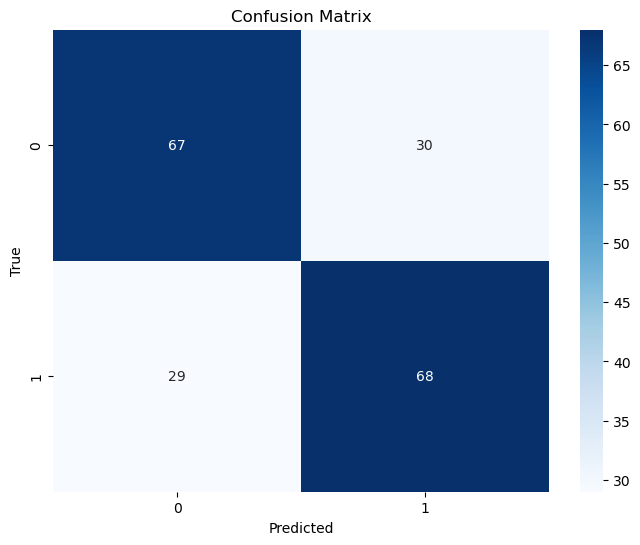

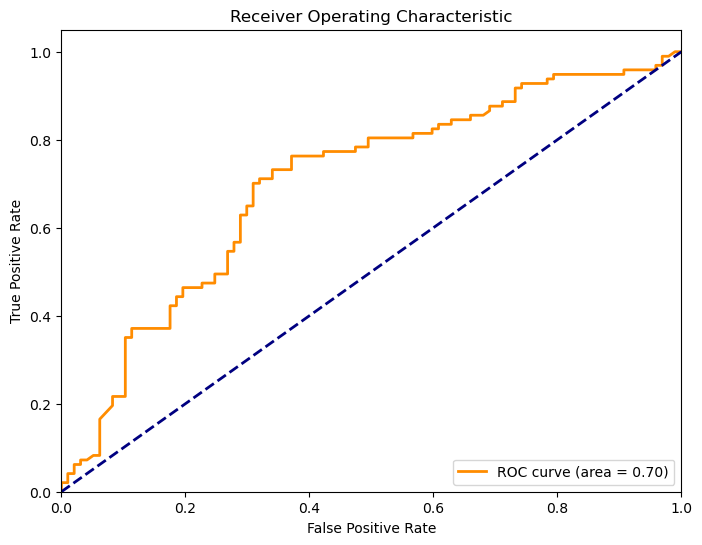


Отчет о классификации:
              precision    recall  f1-score   support

     Class 0       0.70      0.69      0.69        97
     Class 1       0.69      0.70      0.70        97

    accuracy                           0.70       194
   macro avg       0.70      0.70      0.70       194
weighted avg       0.70      0.70      0.70       194



In [198]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Кривая ROC (для бинарной классификации)
if num_classes == 2:
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true_pt, y_probs_pt[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

# Отчет о классификации
from sklearn.metrics import classification_report
print("\nОтчет о классификации:")
print(classification_report(y_true_pt, y_pred_pt, target_names=[f'Class {i}' for i in range(num_classes)]))

## Вывод:
Проанализировав результаты можно сказать, что полученные мною модели достаточно часто ошибаются. 

Как говорится мусор на входе, муссор на выходе. 

Однако, я ни считаю себя вправе без понимания важности доскрипторов, удалять их.
Здесь мы можем пронаблюдать, что модели все таки работают лучше базового решения, которое 0.6 по метрике Roc_AUC, но не могут быть запущены в прод. 

Не могу выделить ни одно модель, они все показали одинаково плохой результат. 
